This notebooks presents [primary blood cancer encyclopedia data](http://pace.embl.de/), in particular the chronic lymphocytic leukemia (CLL) dataset, analysis using `muon`.

Multi-omics integration of different modalities in this dataset [has been originally described in an R notebook here](http://htmlpreview.github.io/?https://github.com/bioFAM/MOFA2_tutorials/blob/master/R_tutorials/CLL.html). For more details please see [a detailed analysis in the original publication](https://www.huber.embl.de/pub/pdf/Dietrich2018.pdf).

In [1]:
import scanpy as sc
import muon as mu
import numpy as np
import pandas as pd
import mofax as mofa

# Load data

Count matrices and metadata [are publicly available as part of this R package](http://bioconductor.org/packages/release/data/experiment/html/MOFAdata.html) or, originally, [here in another R package](http://bioconductor.org/packages/release/data/experiment/html/BloodCancerMultiOmics2017.html). For the purpose of this notebook, those matrices and the metadata table were saved in individual `.tsv` files.

In [2]:
data_dir = "data/CLL"

Metadata:

In [3]:
obs = pd.read_csv(f"{data_dir}/metadata.tsv", sep="\t", index_col='sample')

Matrices with data:

In [4]:
mods = {i:sc.AnnData(pd.read_csv(f"{data_dir}/{i}.csv", index_col=0).T) for i in ("drugs", "methylation", "rna", "mutations")}

A MuData object can be created directly from a dictionary of modalities:

In [5]:
mdata = mu.MuData(mods)
mdata.obs = mdata.obs.join(obs)

In [6]:
mdata

MuData object with n_obs × n_vars = 200 × 9627
  obs:	'Gender', 'age', 'TTT', 'TTD', 'treatedAfter', 'died', 'IGHV_status', 'trisomy12'
  4 modalities
    drugs:	184 x 310
    methylation:	196 x 4248
    rna:	136 x 5000
    mutations:	200 x 69

We can notice that not all samples (patients) have been profiled in each modality. Missing values like that are quite common for biomedical datasets.

# Integrate data

**Multi-omics factor analysis** (MOFA) integration can be run on a MuData object with a single command:
 
```
mu.tl.mofa()
```

In case some samples are missing from some of the modalities, as they are in this CLL dataset, `muon` can be instructed to handle it. One of two modes has to be chosen for that:

1. `use_obs='union'`, which will populate values for missing samples in certain modalities with NAs, or

1. `use_obs='intersection'`, which will use a subset of samples that are present in all modalities.

We will use the first option here.

In [100]:
mu.tl.mofa(mdata, use_obs='union', 
           n_factors=15, convergence_mode='medium',
           outfile="models/CLL_union.hdf5")


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='drugs' group='group1' with N=200 samples and D=310 features...
Loaded view='methylation' group='group1' with N=200 samples and D=4248 features...
Loaded view='rna' group='group1' with N=200 samples and D=5000 features...
Loaded view='mutations' group='group1' with N=200 samples and D=69 features...


Model options:
- Automatic Relevance Determination prior on the fa

We can see that the model has been trained successfully and has managed to learn some meaningful structure in the data:

... storing 'Gender' as categorical
... storing 'treatedAfter' as categorical
... storing 'died' as categorical


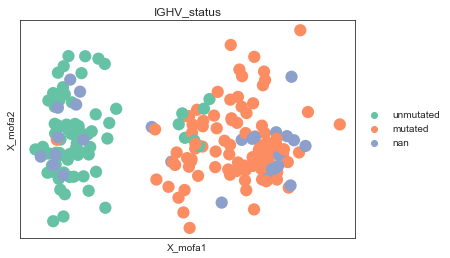

In [9]:
mdata.obs.IGHV_status = mdata.obs.IGHV_status.astype(str).astype("category").cat.rename_categories({"1.0": "mutated", "0.0": "unmutated"})
mu.pl.mofa(mdata, color="IGHV_status")

# Interpret intergrated data

In [10]:
# # Can be used to plot figures with higher resolution:
# from matplotlib import rcParams
# rcParams["figure.dpi"] = 200

In [103]:
model = mofa.mofa_model("models/CLL_union.hdf5")
model

MOFA+ model: CLL union
Samples (cells): 200
Features: 9627
Groups: group1 (200)
Views: drugs (310), methylation (4248), mutations (69), rna (5000)
Factors: 15
Expectations: W, Z

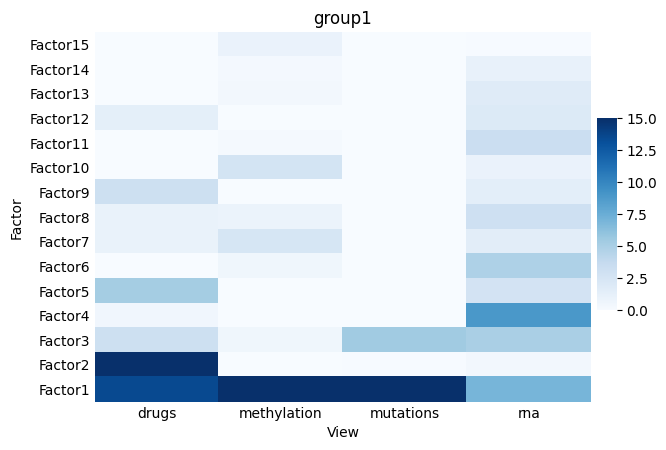

In [107]:
mofa.plot_r2(model, x='View', vmax=15)

We notice e.g. that `Factor 1` captures variability across all modalities, `Factor 2` captures variability across different modalities incl. drug response-specific one, `Factor 4` is quite specific to the RNA modality.

## Factor 1

<AxesSubplot:title={'center':'mutations'}, xlabel='Feature weight'>

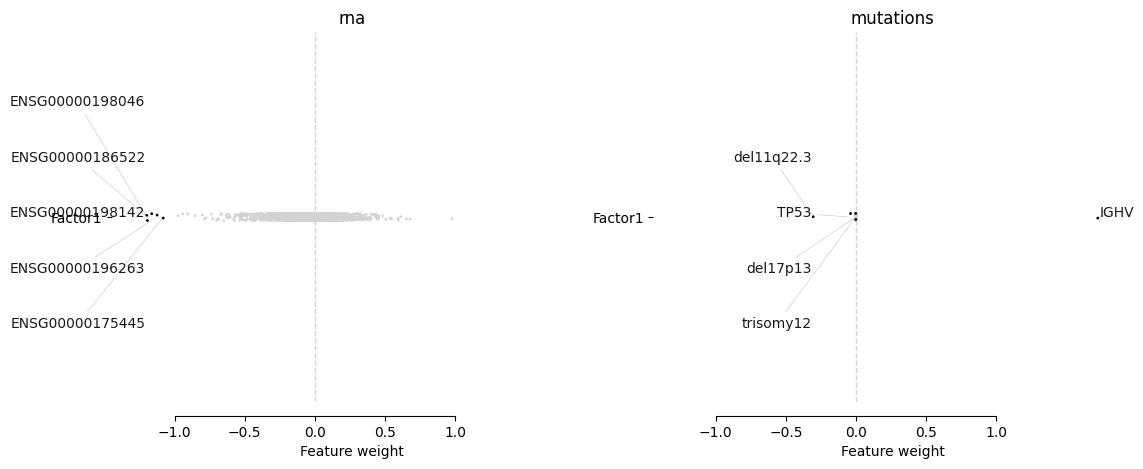

In [108]:
mofa.plot_weights(model, views=['rna', 'mutations'], factors=0, zero_line=True, ncols=2, label_size=10)

We can see that top weights from the RNA modality make sense and are likely to represent the same latent process as IGHV status:

- ENSG00000198046 &rarr; ZNF667 — lnc‐ZNF667‐AS1 [is associated with poor survival and is a promising prognostic biomarker](https://onlinelibrary.wiley.com/doi/abs/10.1111/ijlh.13167)

- ENSG00000186522 &rarr; SEPT10 – its expression [correlates with IGHV status](https://www.nature.com/articles/2404220) (however [there are some caveats](https://www.nature.com/articles/2404867))

- ENSG00000198142 &rarr; SOWAHC – it [has been identified as a prognostic marker for other cancers](https://www.spandidos-publications.com/mmr/21/3/1285)

<AxesSubplot:ylabel='Factor value'>

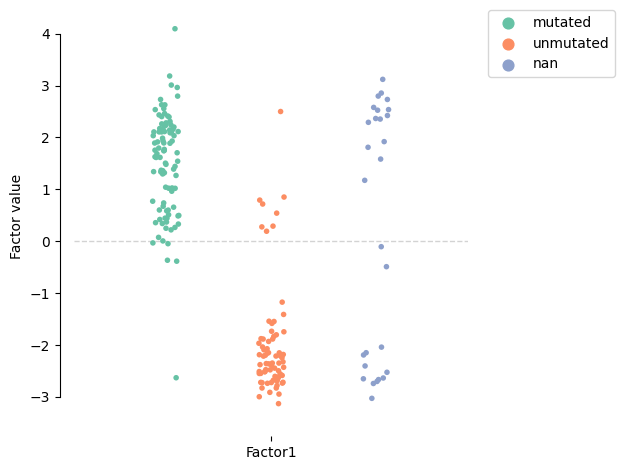

In [134]:
model.metadata.IGHV_status = (
    model.metadata.IGHV_status.astype(str).
        replace({'1.0': 'mutated', '0.0': 'unmutated'}).
        astype('category').cat.reorder_categories(["mutated", "unmutated", "nan"])
)

mofa.plot_factors_violin(model, factors=0, dots=True, violins=False, color="IGHV_status", palette="Set2")

Focusing on the drug response, we notice PF477736 (D_078), AZD7762 (D_020), AT13387 (D_017), and dasatinib (D_050) have the major association with this factor. Those are the exact top associations with the IGHV status [described in the original paper](https://www.huber.embl.de/pub/pdf/Dietrich2018.pdf):

<AxesSubplot:title={'center':'drugs'}, xlabel='Feature weight'>

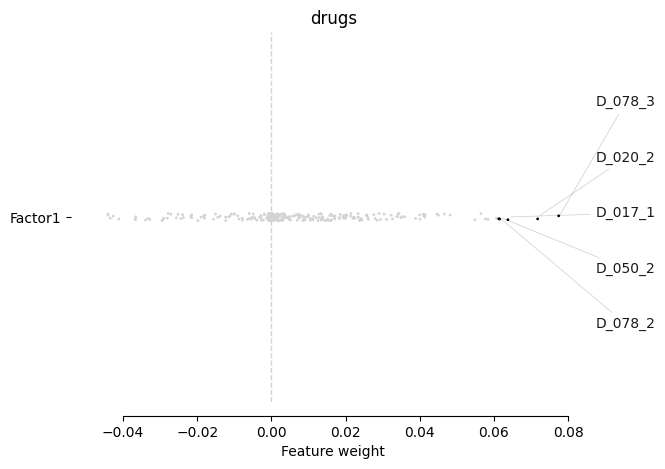

In [163]:
mofa.plot_weights(model, views=['drugs'], factors=0, label_size=10)

## Factor 3

<AxesSubplot:title={'center':'mutations'}, xlabel='Feature weight'>

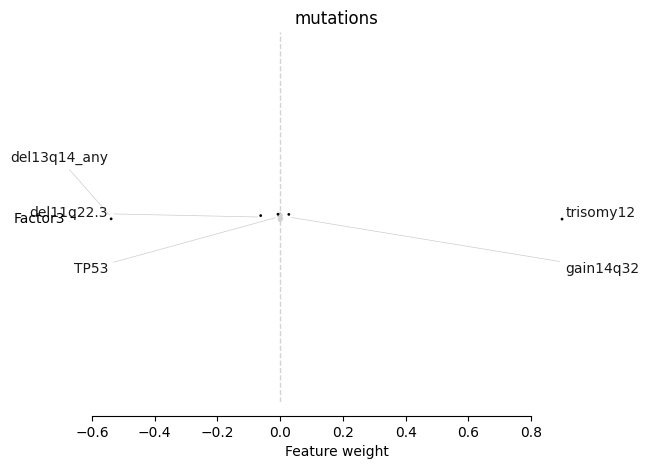

In [164]:
mofa.plot_weights(model, views=['mutations'], factors=2, label_size=10)

We can see how different the values are for this factor depending on the trisomy12:

<AxesSubplot:ylabel='Factor value'>

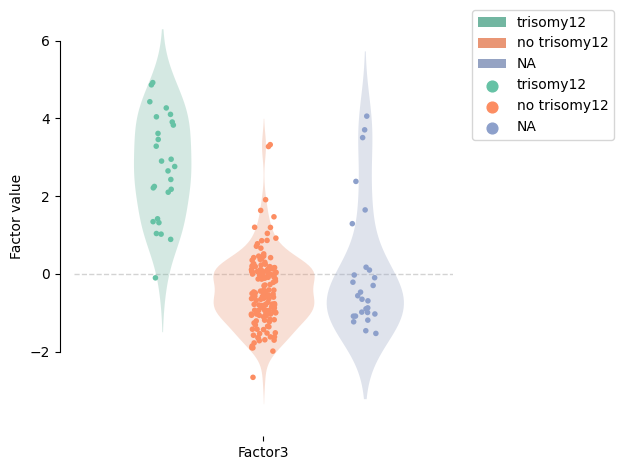

In [154]:
model.metadata.trisomy12 = (
    model.metadata.trisomy12.astype(str).
        replace({'1.0': 'trisomy12', '0.0': 'no trisomy12', 'nan': 'NA'}).
        astype('category').cat.reorder_categories(['trisomy12', 'no trisomy12', 'NA'])
)
mofa.plot_factors_violin(model, factors=2, violins=True, violins_alpha=.3, dots=True, color="trisomy12", palette="Set2")

## Factor 4

<AxesSubplot:title={'center':'rna'}, xlabel='Feature weight'>

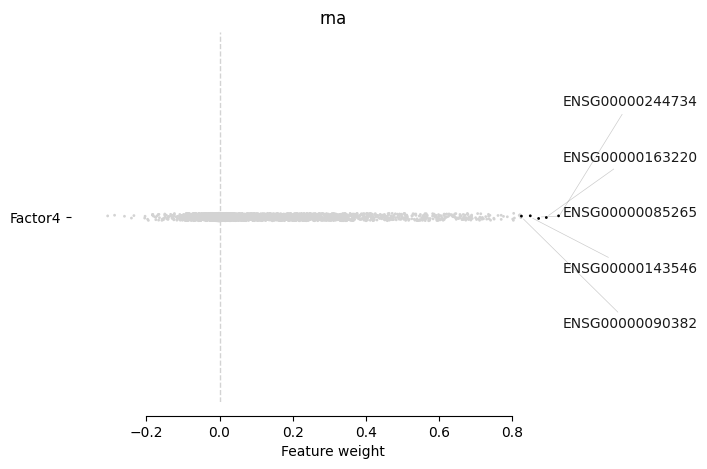

In [178]:
mofa.plot_weights(model, views=['rna'], factors="Factor4", label_size=10)

We can see that top weights from the RNA modality might be related to myeloid leukemia:

- ENSG00000163220 &rarr; S100A9 — has been found [to be highly expressed e.g. in acute myeloid leukemia (AML)](https://ashpublications.org/blood/article/129/14/1980/35876/S100A9-induces-differentiation-of-acute-myeloid) as well as [to be playing its role in CLL as well](https://ashpublications.org/blood/article/130/6/777/36801/S100-A9-protein-in-exosomes-from-chronic?casa_token=1ZQesYETQxAAAAAA:pVhJx_bh-mfzHhyweYqpzUMK9qJqlO1KcGFvKRiMa3KOlKDlzHadjSginPbA7R99N1wfyw)

- ENSG00000085265 &rarr; FCN1 — [is associated with AML and can be considered as a biomarker](https://www.nature.com/articles/s41598-020-67516-2)

- ENSG00000143546 &rarr; S100A8 — same as S100A9

- ENSG00000090382 &rarr; LYZ — myeloid differentiation marker

We, however, do not have clinical covariates related to such sample status in order to corroborate this observation.

<AxesSubplot:title={'center':'ENSG00000085265'}, xlabel='Factor1 value', ylabel='Factor4 value'>

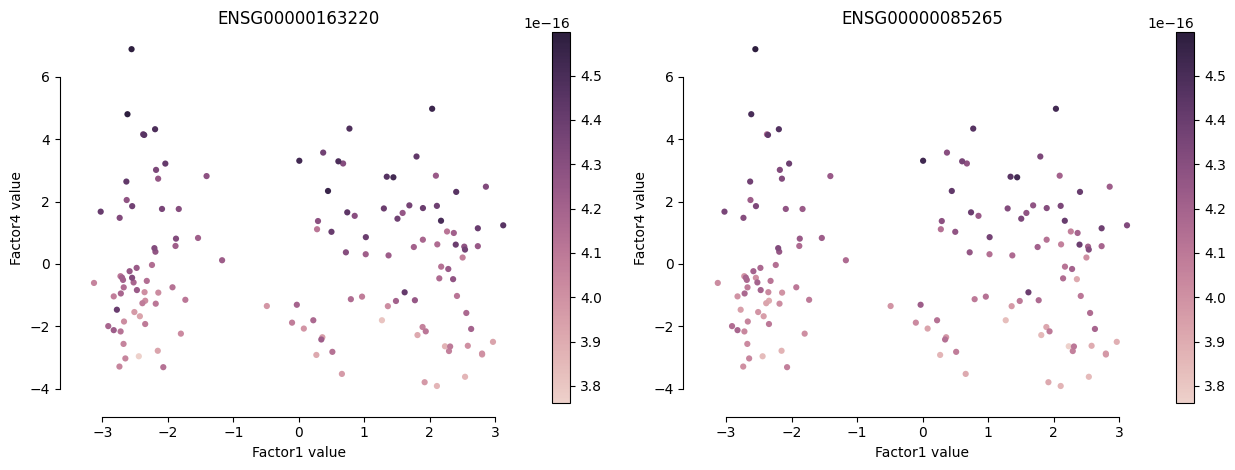

In [181]:
mofa.plot_factors(model, y="Factor4", color=["ENSG00000163220", "ENSG00000085265"], size=20)

## Combinations of factors

A couple of major factors associated with differences in the drug response assay seem to capture molecular profiles of patients so that they could be put into groups according to their somatic mutations status (IGHV and trisomy12).

<AxesSubplot:title={'center':'trisomy12'}, xlabel='Factor1 value', ylabel='Factor3 value'>

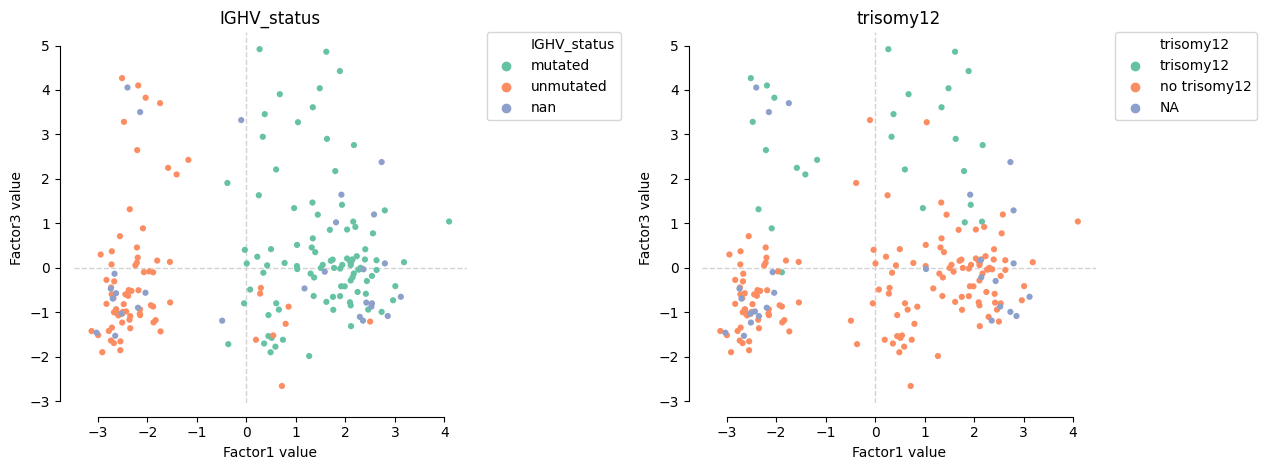

In [162]:
mofa.plot_factors(model, x=0, y=2, color=["IGHV_status", "trisomy12"], size=20, zero_line=True, palette="Set2")